In [ ]:
# Cell 1: Introduction
"""
# Predicting Stock Price Movements Using Machine Learning Techniques

This project aims to predict the next-day stock price movement (Up/Down) for Indian stocks using historical market data and machine learning.
"""

'\n# Predicting Stock Price Movements Using Machine Learning Techniques\n\nThis project aims to predict the next-day stock price movement (Up/Down) for Indian stocks using historical market data and machine learning.\n'

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import warnings
warnings.filterwarnings('ignore')

# Trying to import ta library for technical indicators
try:
    import ta
    TA_AVAILABLE = True
except ImportError:
    print("TA library not available. Using manual calculations.")
    TA_AVAILABLE = False

TA library not available. Using manual calculations.


In [ ]:
# AdvancedStockPredictor Class
class AdvancedStockPredictor:
    def __init__(self, stock_symbol='TATAMOTORS.NS', period='2y'):
        self.stock_symbol = stock_symbol
        self.period = period
        self.data = None
        self.features = None
        self.target = None
        self.model = None
        self.scaler = RobustScaler()
        self.feature_importance = None

    def fetch_data(self):
        """Fetch stock data from Yahoo Finance"""
        print(f"Fetching data for {self.stock_symbol}...")
        try:
            stock = yf.Ticker(self.stock_symbol)
            self.data = stock.history(period=self.period)

            if self.data.empty:
                raise ValueError("No data fetched. Check stock symbol.")

            # Data cleaning
            self.data = self.data.dropna()
            self.data = self.data.sort_index()

            print(f"Data fetched successfully! Shape: {self.data.shape}")
            return self.data

        except Exception as e:
            print(f"Error fetching data: {e}")
            return None

    def calculate_technical_indicators(self):
        """Calculate robust technical indicators"""
        if self.data is None:
            self.fetch_data()

        df = self.data.copy()

        print("Calculating technical indicators...")

        # Basic price features
        df['Returns'] = df['Close'].pct_change()
        df['Price_Range'] = (df['High'] - df['Low']) / df['Close']
        df['Gap'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)

        # Moving Averages
        for window in [5, 10, 20]:
            df[f'SMA_{window}'] = df['Close'].rolling(window).mean()
            df[f'EMA_{window}'] = df['Close'].ewm(span=window).mean()
            df[f'Price_SMA_Ratio_{window}'] = df['Close'] / df[f'SMA_{window}']

        # RSI
        df['RSI_14'] = self.calculate_rsi(df['Close'], 14)

        # MACD
        df['MACD'] = self.calculate_macd(df['Close'])
        df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
        df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

        # Bollinger Bands
        df['BB_Middle'] = df['Close'].rolling(20).mean()
        bb_std = df['Close'].rolling(20).std()
        df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
        df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
        df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])

        # Volume features
        df['Volume_SMA'] = df['Volume'].rolling(10).mean()
        df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA']

        # Volatility
        df['Volatility_10'] = df['Returns'].rolling(10).std()

        # Support and Resistance
        df['Resistance_10'] = df['High'].rolling(10).max()
        df['Support_10'] = df['Low'].rolling(10).min()
        df['Distance_to_Resistance'] = (df['Resistance_10'] - df['Close']) / df['Close']
        df['Distance_to_Support'] = (df['Close'] - df['Support_10']) / df['Close']

        # Lagged returns
        for lag in [1, 2, 3]:
            df[f'Return_lag_{lag}'] = df['Returns'].shift(lag)

        # Remove NaN values
        initial_shape = df.shape[0]
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna()
        final_shape = df.shape[0]
        print(f"Removed {initial_shape - final_shape} rows with NaN/infinite values")

        self.data = df
        print(f"Final data shape: {self.data.shape}")
        return self.data

    def calculate_rsi(self, prices, period=14):
        """Calculate RSI"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    def calculate_macd(self, prices):
        """Calculate MACD"""
        exp1 = prices.ewm(span=12).mean()
        exp2 = prices.ewm(span=26).mean()
        return exp1 - exp2

    def create_target_variable(self):
        """Create target variable: next day price direction"""
        # Use percentage change for better signal
        price_change = self.data['Close'].pct_change().shift(-1)
        self.data['Target'] = (price_change > 0).astype(int)
        self.data = self.data.dropna()
        self.target = self.data['Target']

        print(f"Target distribution:\n{self.target.value_counts()}")
        print(f"Target ratio: {self.target.mean():.3f}")
        return self.target

    def prepare_features(self):
        """Prepare feature set"""
        # Select numerical columns only
        exclude_columns = ['Target']
        numerical_columns = self.data.select_dtypes(include=[np.number]).columns
        feature_columns = [col for col in numerical_columns if col not in exclude_columns]

        self.features = self.data[feature_columns]
        print(f"Number of features: {len(feature_columns)}")
        return self.features

    def train_improved_models(self):
        """Train models with improved feature selection and parameters"""
        if self.features is None or self.target is None:
            self.calculate_technical_indicators()
            self.create_target_variable()
            self.prepare_features()

        X = self.features
        y = self.target

        # Handling remaining NaN values
        X = X.fillna(X.mean())

        # Time-based split
        split_index = int(0.8 * len(X))
        X_train = X.iloc[:split_index]
        X_test = X.iloc[split_index:]
        y_train = y.iloc[:split_index]
        y_test = y.iloc[split_index:]

        print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

        # Scaled features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # models with improved parameters
        models = {
            'Logistic Regression': LogisticRegression(
                random_state=42, max_iter=1000, C=1.0, class_weight='balanced'
            ),
            'Random Forest': RandomForestClassifier(
                n_estimators=200, max_depth=15, min_samples_split=10,
                min_samples_leaf=5, random_state=42, class_weight='balanced'
            ),
            'XGBoost': XGBClassifier(
                n_estimators=200, max_depth=8, learning_rate=0.1,
                subsample=0.8, colsample_bytree=0.8, random_state=42,
                eval_metric='logloss', scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])
            )
        }

        results = {}

        for name, model in models.items():
            print(f"Training {name}...")
            try:
                if 'Logistic' in name:
                    model.fit(X_train_scaled, y_train)
                    y_pred = model.predict(X_test_scaled)
                    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
                    # For Logistic Regression, using coefficient magnitudes as feature importance
                    feature_importance = np.abs(model.coef_[0])
                else:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    y_pred_proba = model.predict_proba(X_test)[:, 1]
                    feature_importance = model.feature_importances_

                accuracy = accuracy_score(y_test, y_pred)
                precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

                results[name] = {
                    'model': model,
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1,
                    'predictions': y_pred,
                    'probabilities': y_pred_proba,
                    'feature_importance': feature_importance
                }

                print(f"{name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

            except Exception as e:
                print(f"Error training {name}: {e}")
                continue

        if not results:
            raise Exception("No models were successfully trained!")

        # Select best model based on accuracy
        best_model_name = max(results, key=lambda x: results[x]['accuracy'])
        self.model = results[best_model_name]['model']

        # Create feature importance dictionary
        self.feature_importance = {}
        if results[best_model_name]['feature_importance'] is not None:
            feature_importance_values = results[best_model_name]['feature_importance']
            feature_names = X.columns
            self.feature_importance = dict(zip(feature_names, feature_importance_values))

        print(f"\nBest Model: {best_model_name}")
        print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")
        print(f"F1 Score: {results[best_model_name]['f1_score']:.4f}")

        return results, X_test, y_test

    def evaluate_models(self, results, X_test, y_test):
        """Evaluate model performance"""
        if not results:
            print("No results to evaluate!")
            return

        # detailed results
        print("\n" + "="*50)
        print("MODEL PERFORMANCE SUMMARY")
        print("="*50)

        for name, result in results.items():
            print(f"\n{name}:")
            print(f"  Accuracy:  {result['accuracy']:.4f}")
            print(f"  Precision: {result['precision']:.4f}")
            print(f"  Recall:    {result['recall']:.4f}")
            print(f"  F1-Score:  {result['f1_score']:.4f}")

        # Best model details
        best_model_name = max(results, key=lambda x: results[x]['accuracy'])
        print(f"\n BEST MODEL: {best_model_name}")
        print(f"Final Test Accuracy: {results[best_model_name]['accuracy']:.4f}")

        # Feature importance for best model
        if self.feature_importance:
            print(f"\nTop 10 Most Important Features:")
            top_features = sorted(self.feature_importance.items(),
                                key=lambda x: x[1], reverse=True)[:10]
            for i, (feature, importance) in enumerate(top_features, 1):
                print(f"  {i:2d}. {feature}: {importance:.4f}")

    def predict_next_day(self):
        """Predict next day movement"""
        if self.model is None:
            print("Please train the model first!")
            return None

        if self.features is None:
            print("No features available!")
            return None

        # latest features
        latest_features = self.features.iloc[-1:].copy()

        try:
            if isinstance(self.model, LogisticRegression):
                latest_features_scaled = self.scaler.transform(latest_features)
                prediction = self.model.predict(latest_features_scaled)[0]
                probability = self.model.predict_proba(latest_features_scaled)[0][1]
            else:
                prediction = self.model.predict(latest_features)[0]
                probability = self.model.predict_proba(latest_features)[0][1]

            direction = "UP" if prediction == 1 else "DOWN"
            confidence = probability if prediction == 1 else (1 - probability)

            result = {
                'prediction': direction,
                'confidence': float(round(confidence * 100, 2)),
                'probability_up': float(round(probability * 100, 2)),
                'probability_down': float(round((1 - probability) * 100, 2)),
                'current_price': float(round(self.data['Close'].iloc[-1], 2)),
                'signal_strength': 'STRONG' if confidence > 0.7 else 'MODERATE' if confidence > 0.6 else 'WEAK'
            }

            return result

        except Exception as e:
            print(f"Error making prediction: {e}")
            return None

print("AdvancedStockPredictor class defined successfully!")

AdvancedStockPredictor class defined successfully!


In [ ]:
# Initialization and fetching data
predictor = AdvancedStockPredictor(stock_symbol='TATAMOTORS.NS', period='2y')
data = predictor.fetch_data()
print("Data Overview:")
print(data.head())
print(f"\nData Shape: {data.shape}")

Fetching data for TATAMOTORS.NS...
Data fetched successfully! Shape: (495, 7)
Data Overview:
                                 Open        High         Low       Close  \
Date                                                                        
2023-11-07 00:00:00+05:30  635.566833  640.395195  633.891684  635.566833   
2023-11-08 00:00:00+05:30  638.523016  639.557648  632.512252  633.152710   
2023-11-09 00:00:00+05:30  634.581478  644.090371  633.300503  639.853210   
2023-11-10 00:00:00+05:30  639.853171  643.400557  634.581439  641.528320   
2023-11-13 00:00:00+05:30  643.449884  644.435259  639.803985  643.696228   

                             Volume  Dividends  Stock Splits  
Date                                                          
2023-11-07 00:00:00+05:30   6588073        0.0           0.0  
2023-11-08 00:00:00+05:30   6551864        0.0           0.0  
2023-11-09 00:00:00+05:30  10155047        0.0           0.0  
2023-11-10 00:00:00+05:30   6425792        0.0      

In [ ]:
# technical indicators calculation
data_with_indicators = predictor.calculate_technical_indicators()
print("Data with Technical Indicators:")

# Display available columns
print("Available columns:", list(predictor.data.columns)[:10])  # first 10 columns
print(data_with_indicators[['Close', 'RSI_14', 'SMA_20', 'EMA_20', 'MACD']].tail())

Calculating technical indicators...
Removed 19 rows with NaN/infinite values
Final data shape: (476, 37)
Data with Technical Indicators:
Available columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Returns', 'Price_Range', 'Gap']
                                Close     RSI_14      SMA_20      EMA_20  \
Date                                                                       
2025-11-03 00:00:00+05:30  417.000000  10.268949  488.792500  476.820231   
2025-11-04 00:00:00+05:30  406.500000  60.635212  473.484999  470.123066   
2025-11-05 00:00:00+05:30  406.500000  66.525863  458.907500  464.063726   
2025-11-06 00:00:00+05:30  407.850006  62.923989  445.222501  458.710039   
2025-11-07 00:00:00+05:30  405.700012  60.178968  431.452502  453.661465   

                                MACD  
Date                                  
2025-11-03 00:00:00+05:30 -67.517673  
2025-11-04 00:00:00+05:30 -64.842446  
2025-11-05 00:00:00+05:30 -62.007525  
2025-11-06 

In [ ]:
# target variable
target = predictor.create_target_variable()
print("Target variable distribution:")
print(target.value_counts())

Target distribution:
Target
0    248
1    228
Name: count, dtype: int64
Target ratio: 0.479
Target variable distribution:
Target
0    248
1    228
Name: count, dtype: int64


In [ ]:
# Features Preparation
features = predictor.prepare_features()
print("Feature Overview:")
print(features.describe())

Number of features: 37
Feature Overview:
              Open         High          Low        Close        Volume  \
count   476.000000   476.000000   476.000000   476.000000  4.760000e+02   
mean    803.492161   812.058958   792.229126   801.445140  1.283330e+07   
std     160.054058   161.450688   157.485289   159.444617  7.756853e+06   
min     395.450012   400.450012   376.299988   390.850006  0.000000e+00   
25%     688.937515   694.024637   680.152179   687.275024  8.090793e+06   
50%     773.103014   785.199023   763.894087   771.413422  1.102808e+07   
75%     950.874526   959.213254   938.384920   950.047791  1.446367e+07   
max    1157.051852  1168.949630  1135.536938  1151.945801  5.981103e+07   

        Dividends  Stock Splits     Returns  Price_Range         Gap  ...  \
count  476.000000         476.0  476.000000   476.000000  476.000000  ...   
mean     0.025210           0.0   -0.000733     0.024748    0.001637  ...   
std      0.388513           0.0    0.026185     0.01

In [ ]:
# Training
results, X_test, y_test = predictor.train_improved_models()

Training set: (380, 37), Test set: (96, 37)
Training Logistic Regression...
Logistic Regression - Accuracy: 0.4479, F1: 0.5310
Training Random Forest...
Random Forest - Accuracy: 0.5208, F1: 0.5000
Training XGBoost...
XGBoost - Accuracy: 0.5833, F1: 0.5556

Best Model: XGBoost
Accuracy: 0.5833
F1 Score: 0.5556


In [ ]:
# Evaluation
predictor.evaluate_models(results, X_test, y_test)


MODEL PERFORMANCE SUMMARY

Logistic Regression:
  Accuracy:  0.4479
  Precision: 0.4348
  Recall:    0.6818
  F1-Score:  0.5310

Random Forest:
  Accuracy:  0.5208
  Precision: 0.4792
  Recall:    0.5227
  F1-Score:  0.5000

XGBoost:
  Accuracy:  0.5833
  Precision: 0.5435
  Recall:    0.5682
  F1-Score:  0.5556

 BEST MODEL: XGBoost
Final Test Accuracy: 0.5833

Top 10 Most Important Features:
   1. EMA_5: 0.0723
   2. Resistance_10: 0.0521
   3. High: 0.0381
   4. RSI_14: 0.0338
   5. EMA_10: 0.0326
   6. Distance_to_Resistance: 0.0326
   7. BB_Lower: 0.0324
   8. MACD: 0.0318
   9. Low: 0.0311
  10. Support_10: 0.0311


In [ ]:
# Cell 11: Visualization Functions
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np

def create_visualizations(predictor, results, X_test, y_test):
    """Create comprehensive visualizations for the stock prediction project"""

    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(20, 15))

    # 1. Confusion Matrices
    plt.subplot(3, 3, 1)
    model_names = list(results.keys())
    for i, model_name in enumerate(model_names):
        plt.subplot(3, 3, i+1)
        y_pred = results[model_name]['predictions']
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
        plt.title(f'{model_name} Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')

    # 2. ROC Curves
    plt.subplot(3, 3, 4)
    for model_name in model_names:
        y_pred_proba = results[model_name]['probabilities']
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Model Comparison')
    plt.legend(loc="lower right")
    plt.grid(True)

    # 3. Feature Importance
    plt.subplot(3, 3, 5)
    if predictor.feature_importance:
        top_features = sorted(predictor.feature_importance.items(),
                            key=lambda x: x[1], reverse=True)[:15]
        features, importance = zip(*top_features)
        y_pos = np.arange(len(features))

        plt.barh(y_pos, importance, align='center', alpha=0.8, color='steelblue')
        plt.yticks(y_pos, features)
        plt.xlabel('Feature Importance Score')
        plt.title('Top 15 Feature Importance (XGBoost)')
        plt.gca().invert_yaxis()

    # 4. Model Performance Comparison
    plt.subplot(3, 3, 6)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    model_performance = []

    for model_name in model_names:
        result = results[model_name]
        model_performance.append([
            result['accuracy'],
            result['precision'],
            result['recall'],
            result['f1_score']
        ])

    x = np.arange(len(metrics))
    width = 0.25

    for i, model_name in enumerate(model_names):
        plt.bar(x + i*width, model_performance[i], width, label=model_name, alpha=0.8)

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + width, metrics)
    plt.legend()
    plt.ylim(0, 1)

    # 5. Actual vs Predicted (Time Series)
    plt.subplot(3, 1, 3)
    best_model_name = max(results, key=lambda x: results[x]['accuracy'])
    y_pred_best = results[best_model_name]['predictions']

    # Create a simple time series plot
    days = range(len(y_test))
    plt.plot(days, y_test.values, label='Actual', marker='o', linewidth=2)
    plt.plot(days, y_pred_best, label=f'Predicted ({best_model_name})',
             marker='x', linestyle='--', alpha=0.7)

    plt.xlabel('Trading Days (Test Period)')
    plt.ylabel('Price Direction (0=Down, 1=Up)')
    plt.title('Actual vs Predicted Price Movements - Test Period')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig

def plot_stock_trend(predictor):
    """Plot the stock price trend with technical indicators"""
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))

    data = predictor.data

    # 1. Price and Moving Averages
    axes[0].plot(data.index, data['Close'], label='Close Price', linewidth=2, color='black')
    axes[0].plot(data.index, data['SMA_20'], label='SMA 20', linestyle='--', alpha=0.7)
    axes[0].plot(data.index, data['EMA_20'], label='EMA 20', linestyle='--', alpha=0.7)
    axes[0].fill_between(data.index, data['BB_Upper'], data['BB_Lower'],
                        alpha=0.2, label='Bollinger Bands', color='gray')
    axes[0].set_title(f'{predictor.stock_symbol} - Price Trend & Technical Indicators')
    axes[0].set_ylabel('Price (₹)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 2. RSI
    axes[1].plot(data.index, data['RSI_14'], label='RSI 14', color='purple', linewidth=2)
    axes[1].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought (70)')
    axes[1].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold (30)')
    axes[1].set_title('Relative Strength Index (RSI)')
    axes[1].set_ylabel('RSI')
    axes[1].set_ylim(0, 100)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # 3. MACD
    axes[2].plot(data.index, data['MACD'], label='MACD', color='blue', linewidth=2)
    axes[2].plot(data.index, data['MACD_Signal'], label='Signal Line', color='red', linewidth=1)
    axes[2].bar(data.index, data['MACD_Histogram'],
                alpha=0.3, label='MACD Histogram', color='gray')
    axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[2].set_title('MACD Indicator')
    axes[2].set_ylabel('MACD')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig

def plot_correlation_heatmap(predictor):
    """Plot correlation heatmap of features"""
    # Select only numerical features for correlation
    numerical_data = predictor.data.select_dtypes(include=[np.number])

    # Calculate correlation matrix
    corr_matrix = numerical_data.corr()

    # Plot only correlations with target if target exists
    if 'Target' in corr_matrix.columns:
        target_corr = corr_matrix['Target'].sort_values(ascending=False)

        plt.figure(figsize=(10, 8))
        top_corr_features = target_corr[1:16]  # Exclude target itself
        top_corr_features.plot(kind='barh', color='steelblue')
        plt.title('Top 15 Features Correlation with Target Variable')
        plt.xlabel('Correlation Coefficient')
        plt.tight_layout()
        plt.show()

    # Plot full correlation heatmap for top correlated features
    plt.figure(figsize=(12, 10))
    top_features = corr_matrix.nlargest(10, 'Target')['Target'].index
    top_corr_matrix = numerical_data[top_features].corr()

    mask = np.triu(np.ones_like(top_corr_matrix, dtype=bool))
    sns.heatmap(top_corr_matrix, mask=mask, annot=True, cmap='coolwarm',
                center=0, square=True, fmt='.2f')
    plt.title('Correlation Heatmap - Top Features with Target')
    plt.tight_layout()
    plt.show()

def plot_prediction_distribution(results, y_test):
    """Plot the distribution of predictions and probabilities"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for i, model_name in enumerate(results.keys()):
        if i >= 4:  # Only plot first 4 models
            break

        y_pred = results[model_name]['predictions']
        y_pred_proba = results[model_name]['probabilities']

        # Prediction distribution
        axes[i].hist(y_pred_proba, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Decision Boundary')
        axes[i].set_xlabel('Predicted Probability')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'{model_name} - Prediction Distribution')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Visualization functions defined successfully!")

Visualization functions defined successfully!


Generating Comprehensive Visualizations...
1. Creating main visualization dashboard...


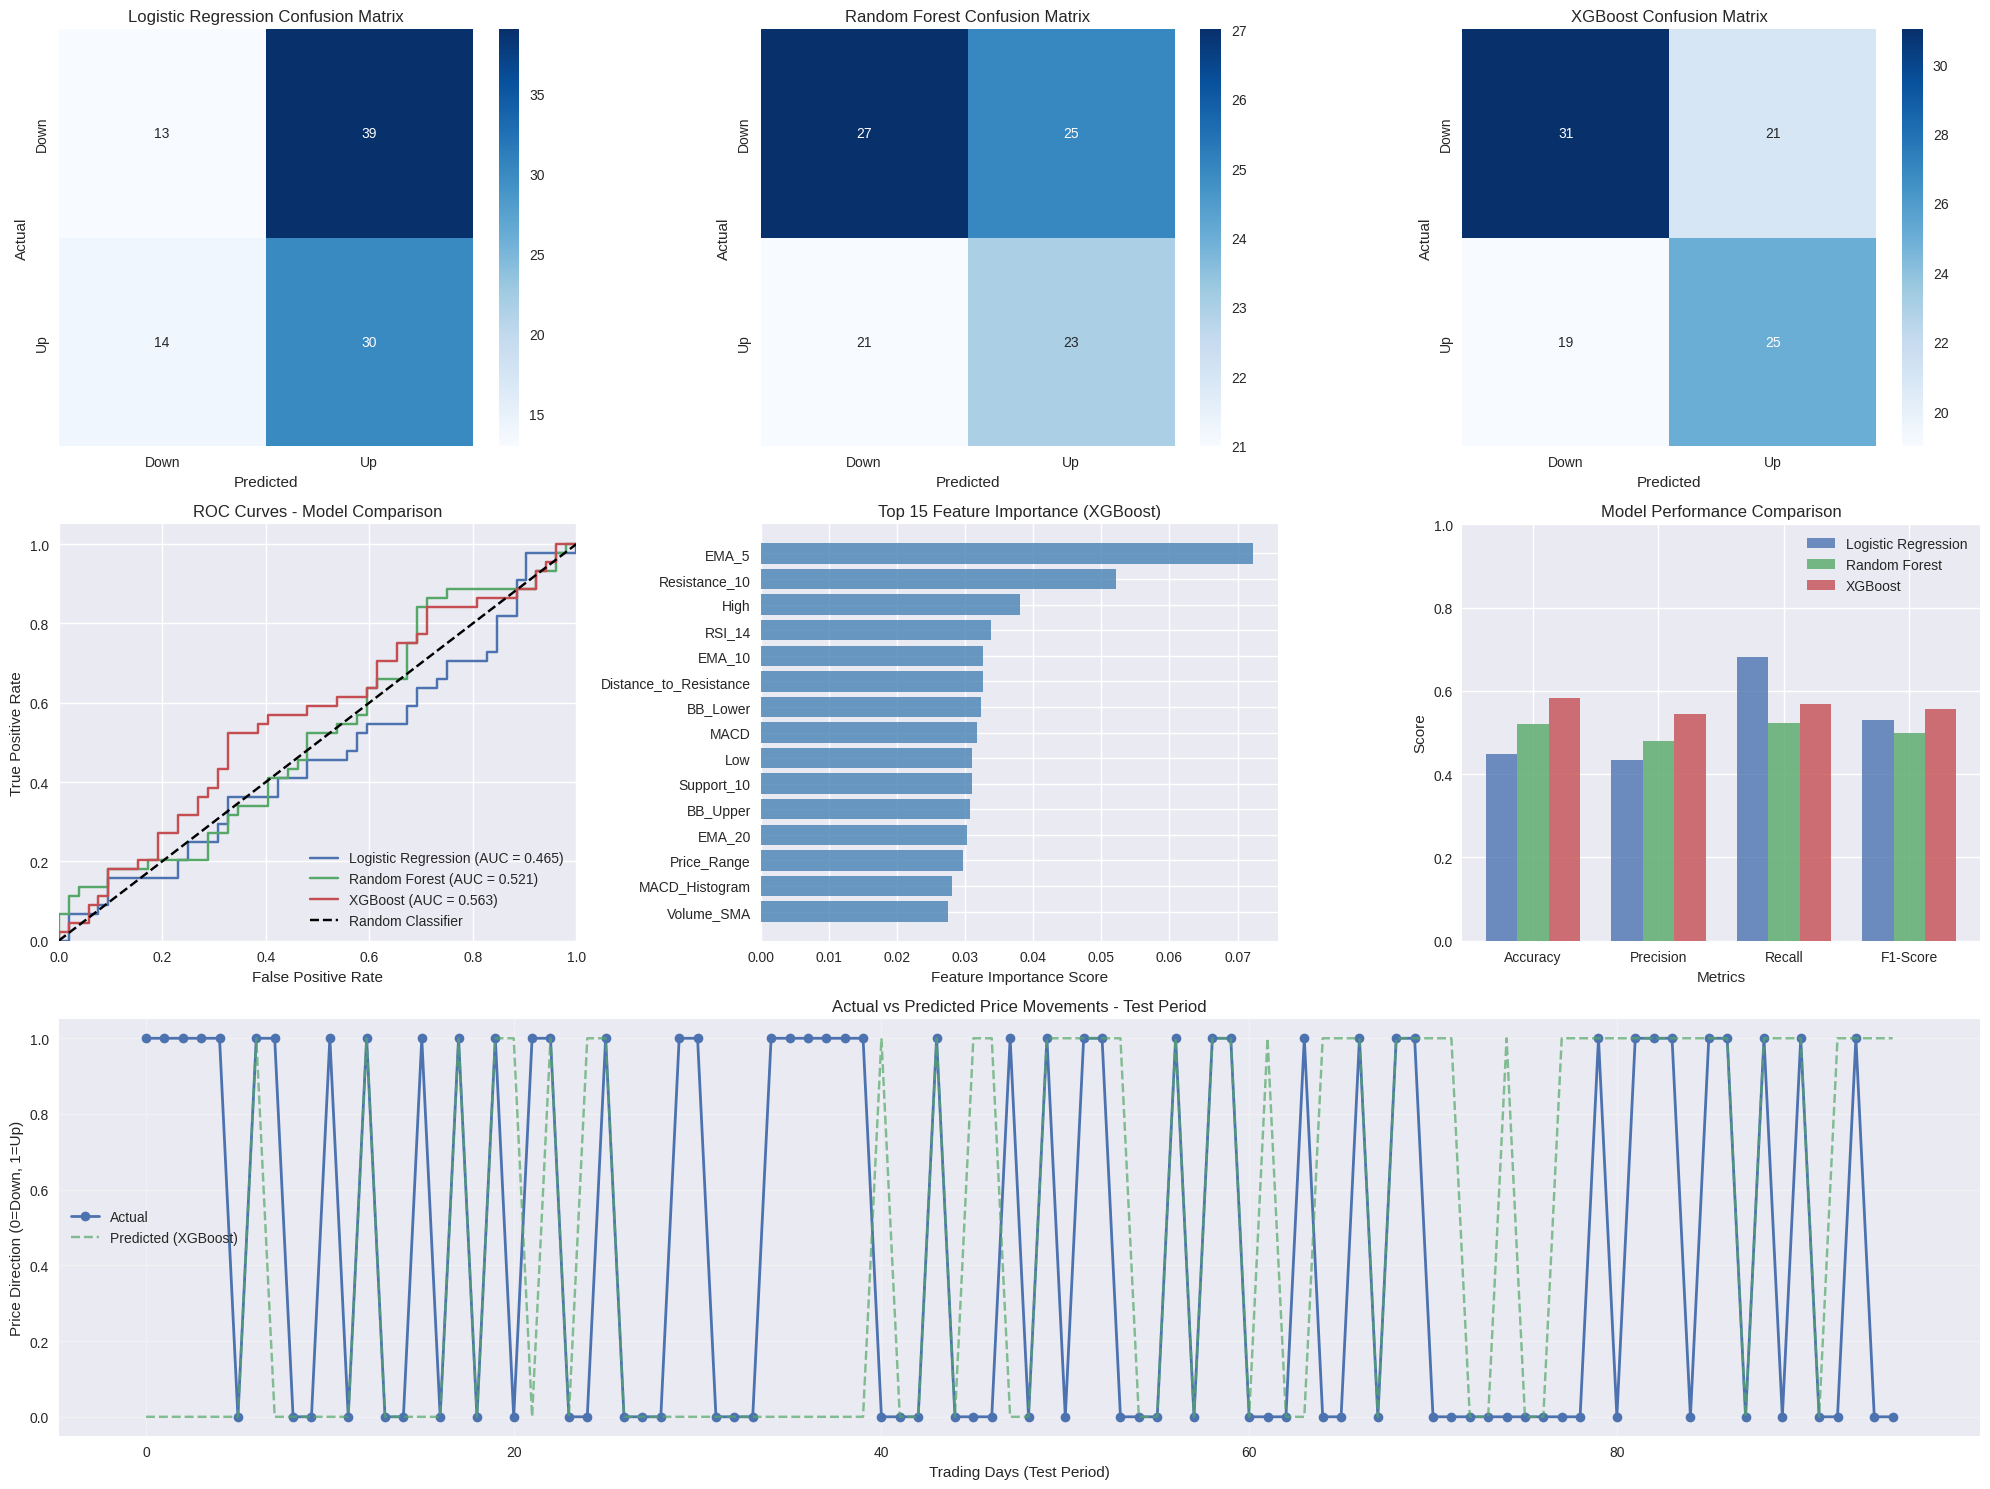

2. Creating stock trend visualization...


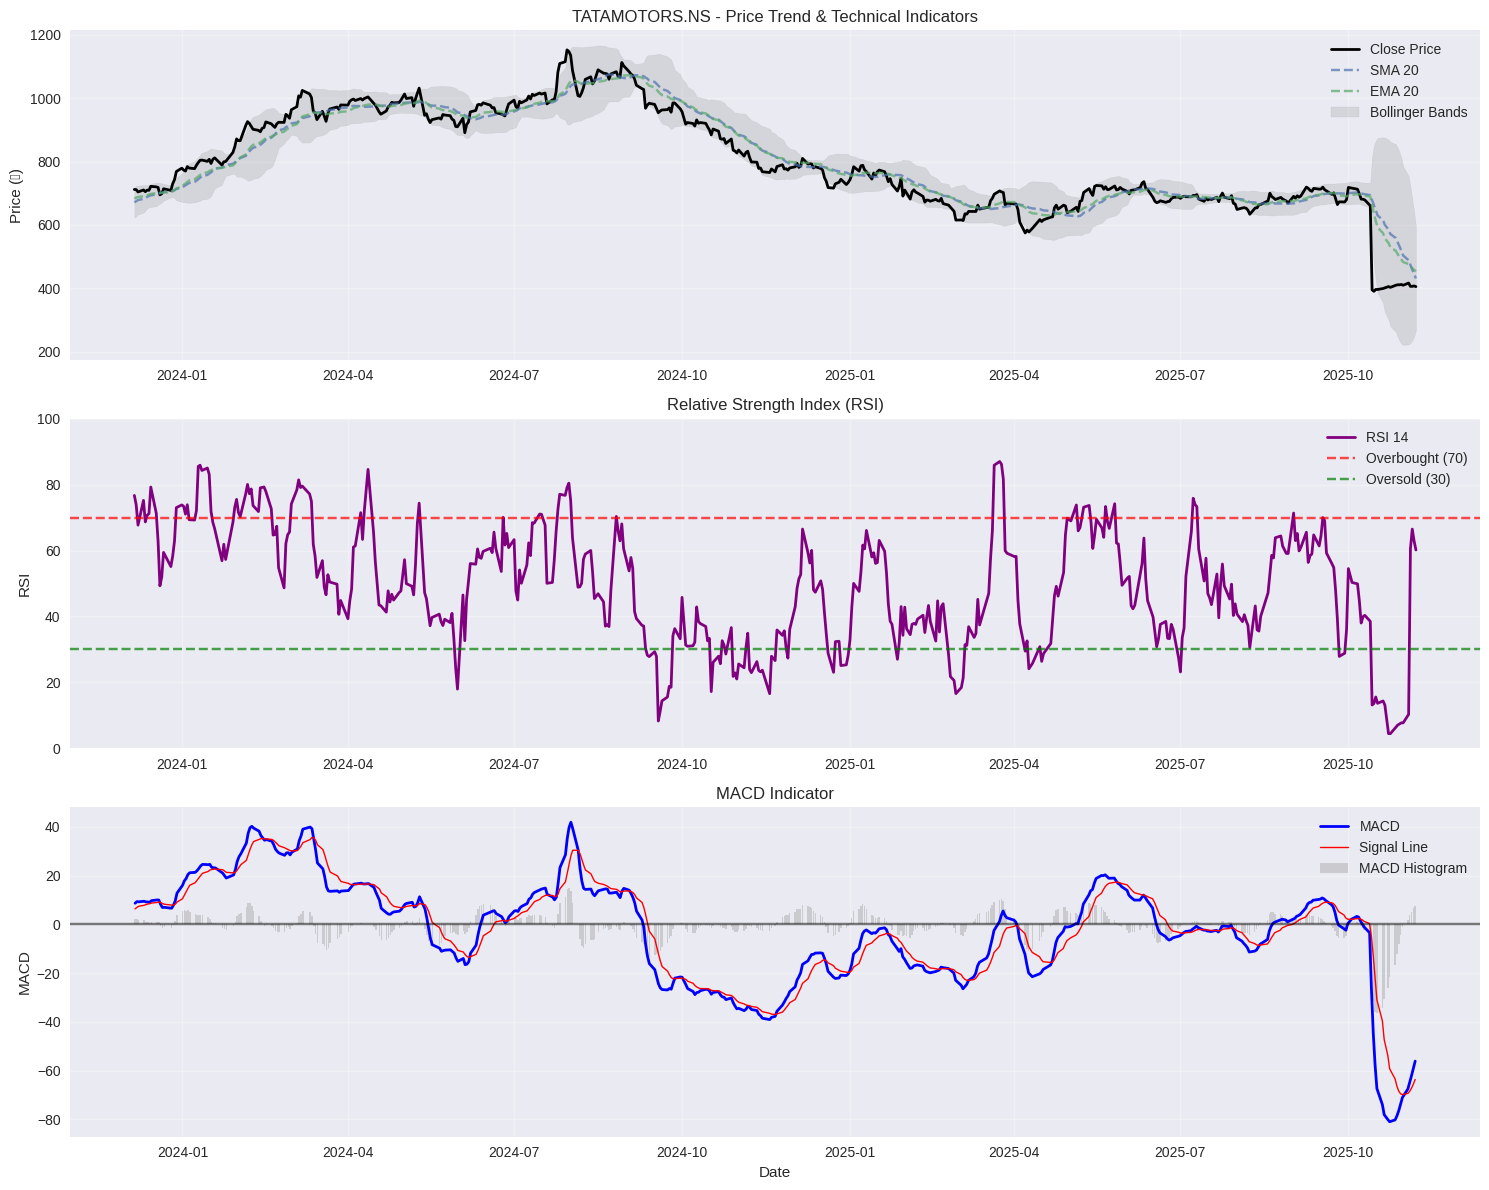

3. Creating correlation heatmaps...


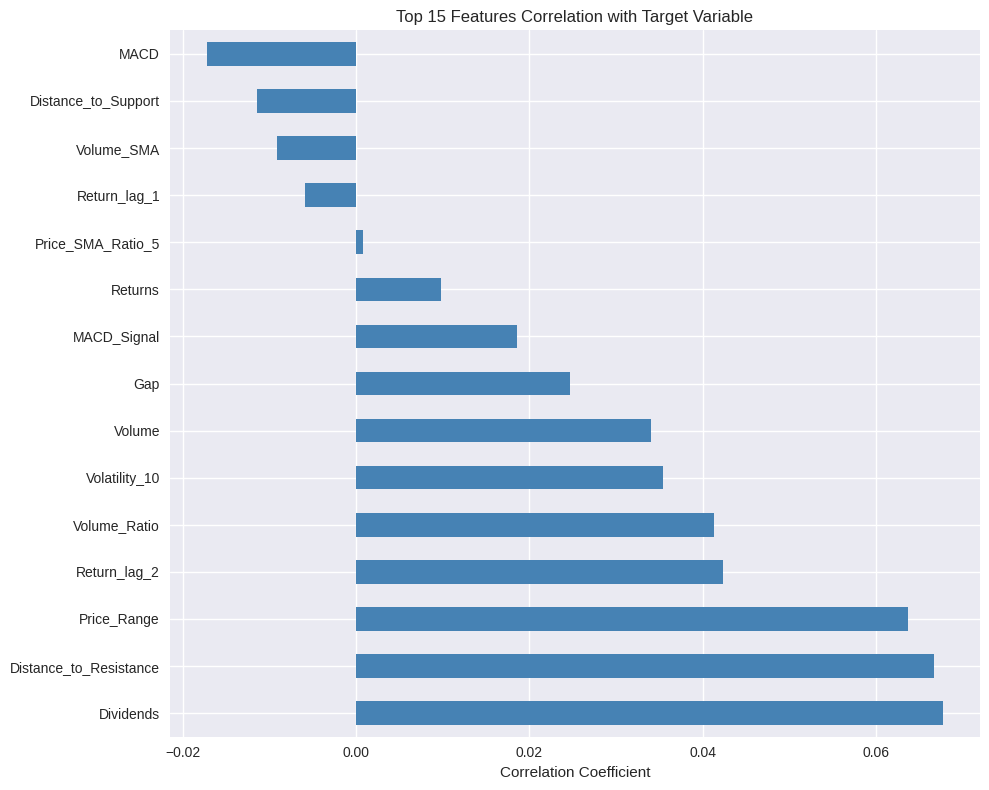

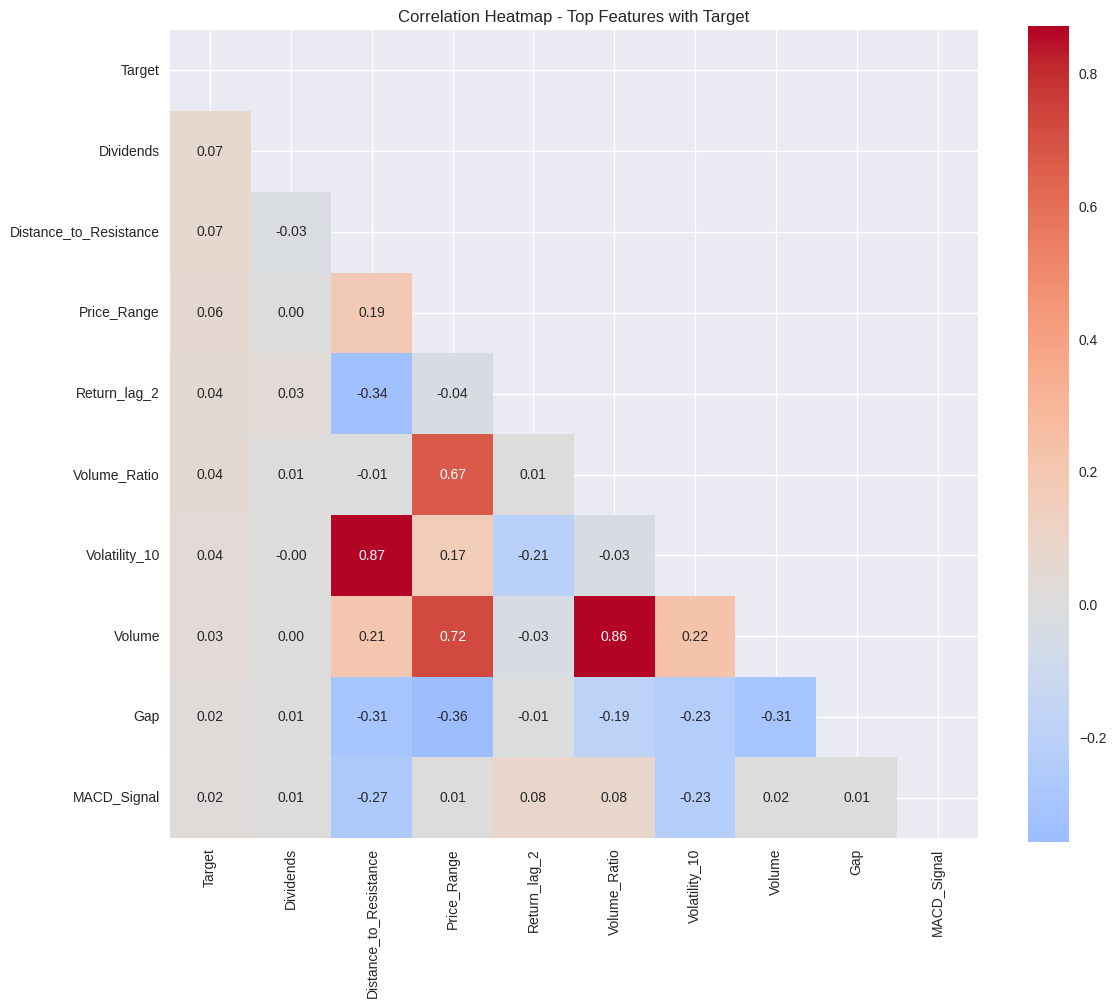

4. Creating prediction distribution plots...


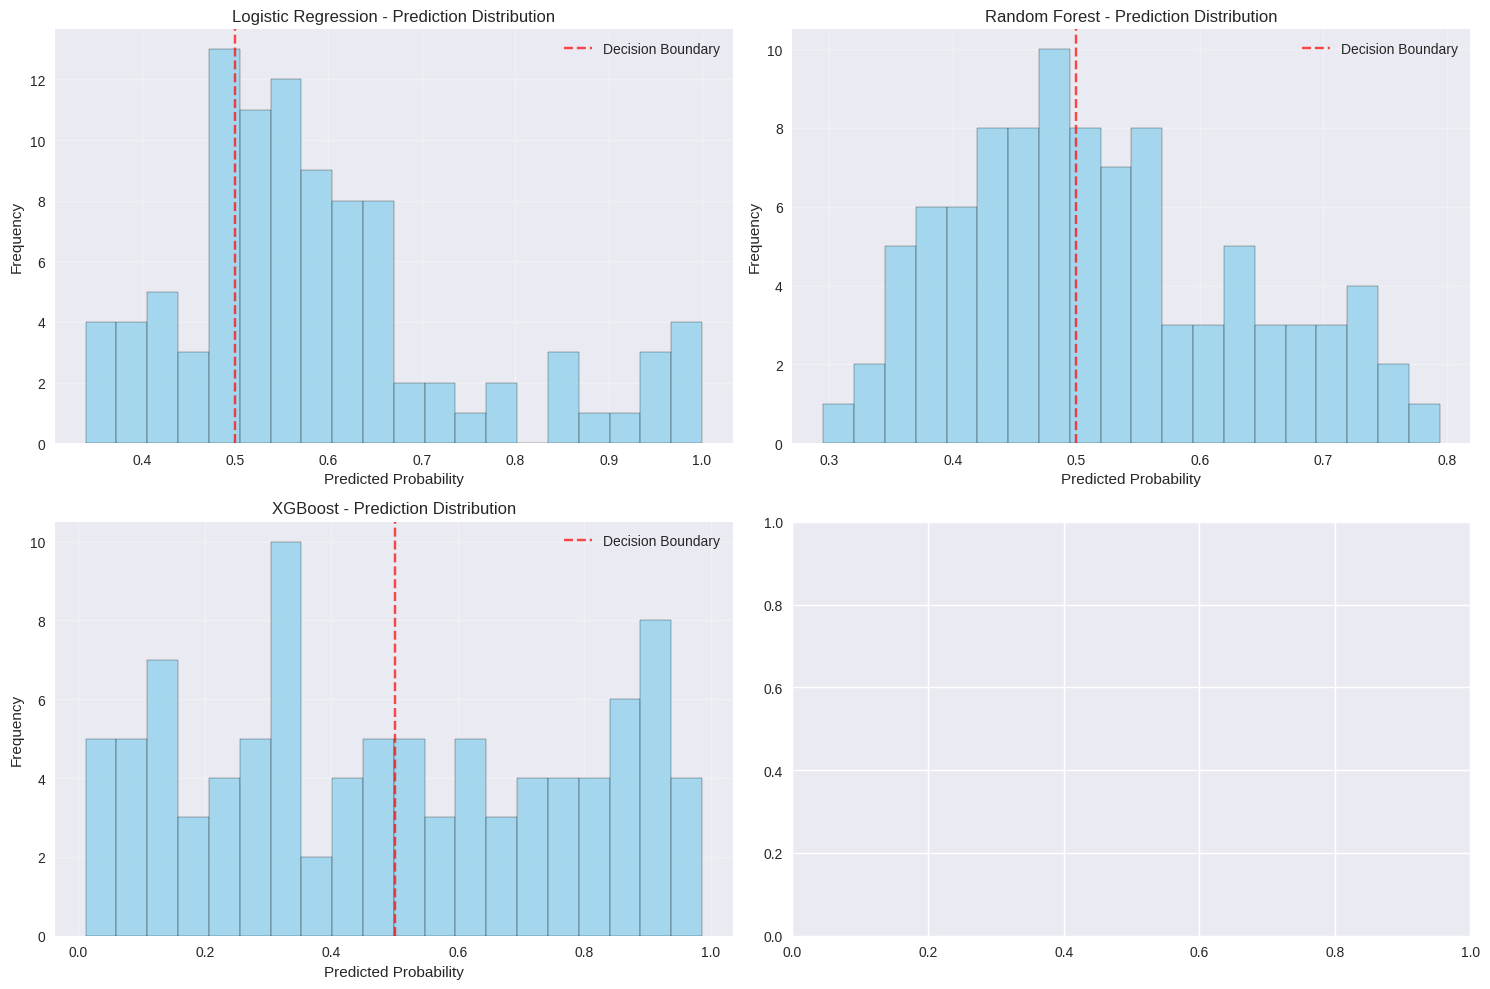

All visualizations completed successfully!


In [ ]:
# Cell 12: Generate All Visualizations
print("Generating Comprehensive Visualizations...")

# 1. Main comprehensive visualization
print("1. Creating main visualization dashboard...")
main_fig = create_visualizations(predictor, results, X_test, y_test)

# 2. Stock trend with technical indicators
print("2. Creating stock trend visualization...")
trend_fig = plot_stock_trend(predictor)

# 3. Correlation analysis
print("3. Creating correlation heatmaps...")
correlation_fig = plot_correlation_heatmap(predictor)

# 4. Prediction distribution
print("4. Creating prediction distribution plots...")
distribution_fig = plot_prediction_distribution(results, y_test)

print("All visualizations completed successfully!")

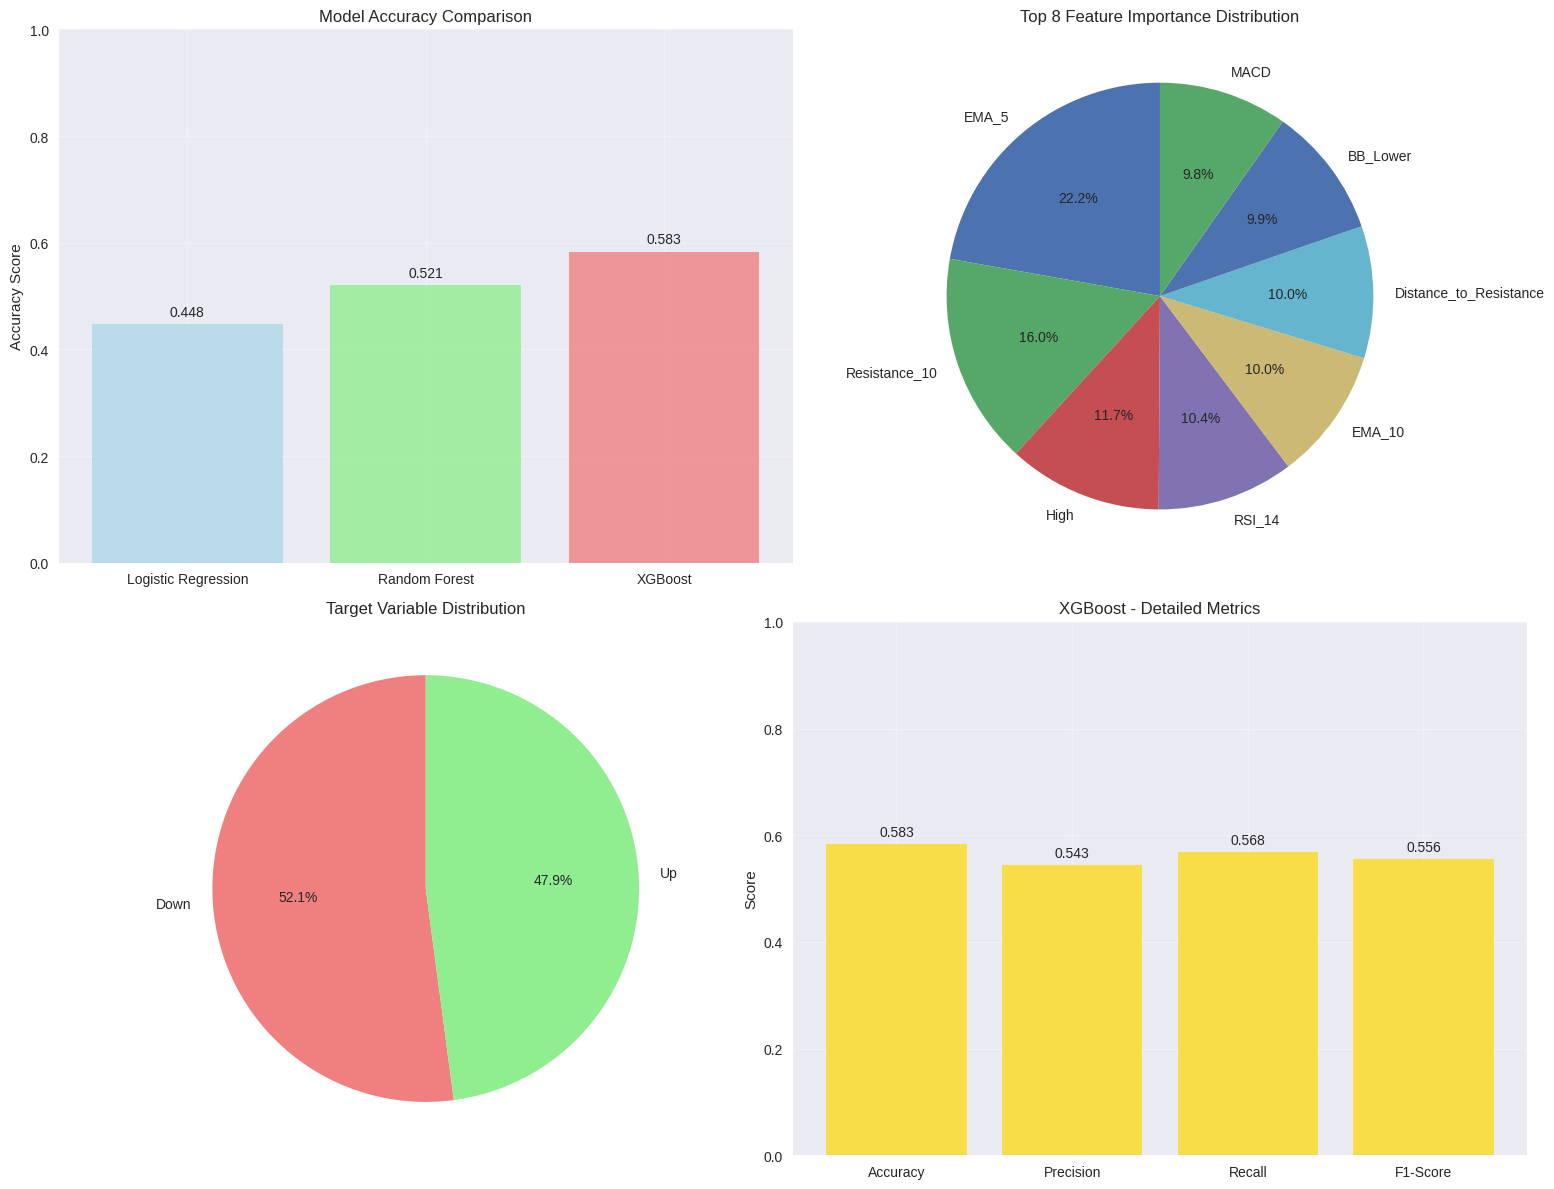

PERFORMANCE SUMMARY
Stock Analyzed: TATAMOTORS.NS
Dataset Size: 476 samples
Number of Features: 37
Best Model: XGBoost
Best Accuracy: 0.5833
Target Distribution: {0: np.int64(248), 1: np.int64(228)}


In [ ]:
# Cell 14: Summary Statistics and Performance Overview

def create_performance_summary(predictor, results, y_test):
    """Create a comprehensive performance summary visualization"""
    fig = plt.figure(figsize=(16, 12))

    # 1. Overall Performance Summary
    plt.subplot(2, 2, 1)
    models = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in models]

    bars = plt.bar(models, accuracies, color=['lightblue', 'lightgreen', 'lightcoral'], alpha=0.8)
    plt.ylabel('Accuracy Score')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 1)

    # Add value labels on bars
    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{accuracy:.3f}', ha='center', va='bottom')

    plt.grid(True, alpha=0.3)

    # 2. Feature Importance (Top 8)
    plt.subplot(2, 2, 2)
    if predictor.feature_importance:
        top_features = sorted(predictor.feature_importance.items(),
                            key=lambda x: x[1], reverse=True)[:8]
        features, importance = zip(*top_features)

        plt.pie(importance, labels=features, autopct='%1.1f%%', startangle=90)
        plt.title('Top 8 Feature Importance Distribution')

    # 3. Target Distribution
    plt.subplot(2, 2, 3)
    target_counts = predictor.target.value_counts()
    colors = ['lightcoral', 'lightgreen']
    plt.pie(target_counts.values, labels=['Down', 'Up'], autopct='%1.1f%%',
            colors=colors, startangle=90)
    plt.title('Target Variable Distribution')

    # 4. Best Model Detailed Metrics
    plt.subplot(2, 2, 4)
    best_model_name = max(results, key=lambda x: results[x]['accuracy'])
    best_result = results[best_model_name]

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [best_result['accuracy'], best_result['precision'],
             best_result['recall'], best_result['f1_score']]

    bars = plt.bar(metrics, values, color='gold', alpha=0.7)
    plt.ylabel('Score')
    plt.title(f'{best_model_name} - Detailed Metrics')
    plt.ylim(0, 1)

    # Add value labels
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("="*60)
    print("PERFORMANCE SUMMARY")
    print("="*60)
    print(f"Stock Analyzed: {predictor.stock_symbol}")
    print(f"Dataset Size: {predictor.data.shape[0]} samples")
    print(f"Number of Features: {len(predictor.features.columns)}")
    print(f"Best Model: {best_model_name}")
    print(f"Best Accuracy: {best_result['accuracy']:.4f}")
    print(f"Target Distribution: {dict(target_counts)}")
    print("="*60)

# Create final summary
create_performance_summary(predictor, results, y_test)

In [124]:
# Cell 10: Predict next day
next_day_pred = predictor.predict_next_day()
if next_day_pred:
    print(f"\nNEXT DAY PREDICTION:")
    print(f"Stock: {predictor.stock_symbol}")
    print(f"Current Price: ₹{next_day_pred['current_price']}")
    print(f"Direction: {next_day_pred['prediction']}")
    print(f"Confidence: {next_day_pred['confidence']}%")
    print(f"Signal Strength: {next_day_pred['signal_strength']}")
    print(f"Probability UP: {next_day_pred['probability_up']}%")
    print(f"Probability DOWN: {next_day_pred['probability_down']}%")


NEXT DAY PREDICTION:
Stock: TATAMOTORS.NS
Current Price: ₹405.7
Direction: UP
Confidence: 90.7300033569336%
Signal Strength: STRONG
Probability UP: 90.7300033569336%
Probability DOWN: 9.270000457763672%
